# Section 5.4 — Bayesian difference between means

This notebook contains the code examples from [Section 5.4 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g


#### Notebook setup

In [1]:
# Ensure required Python modules are installed
%pip install --quiet numpy scipy seaborn statsmodels bambi==0.15.0 pymc==5.23.0 ministats

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={"font.family": "serif",
        "font.serif": ["Palatino", "DejaVu Serif", "serif"],
        "figure.figsize": (5,3)},
)
%config InlineBackend.figure_format = "retina"

<Figure size 640x480 with 0 Axes>

In [4]:
# Simple float __repr__  
if int(np.__version__.split(".")[0]) >= 2:
    np.set_printoptions(legacy='1.25')

In [5]:
# Download datasets/ directory if necessary
from ministats import ensure_datasets
ensure_datasets()

datasets/ directory present and ready.


## Introduciton

We'll now  revisit the problem of comparison between two groups from a Bayesian perspective.

## Model

The data models for the two groups are based on Student’s $t$-distribution:

$$
    X \sim \mathcal{T}(\nu, M_X, \Sigma_X)
    \qquad
    \text{and}
    \qquad
    Y \sim \mathcal{T}(\nu, M_Y, \Sigma_Y).
$$

We'll use a normal prior for the means,
half-$t$ priors for standard deviations,
and a gamma distribution for the degrees of freedom parameter:

$$
    M_X, M_Y \sim \mathcal{N}(\mu_{M}, \sigma_{M}),
    \quad
    \Sigma_X, \Sigma_Y \sim \mathcal{T}^+\!(\nu_{\Sigma}, \sigma_{\Sigma}),
    \quad
    \nu \sim \textrm{Gamma}(\alpha,\beta).
$$


### Bambi formula objects

In [6]:
import bambi as bmb
formula = bmb.Formula("y ~ 0 + group",
                      "sigma ~ 0 + group")
formula

Formula('y ~ 0 + group', 'sigma ~ 0 + group')

In [7]:
formula.main, formula.additionals

('y ~ 0 + group', ('sigma ~ 0 + group',))

In [8]:
formula.get_all_formulas()

['y ~ 0 + group', 'sigma ~ 0 + group']

### Choosing priors for log-sigma

#### Normal distribution for log-sigma


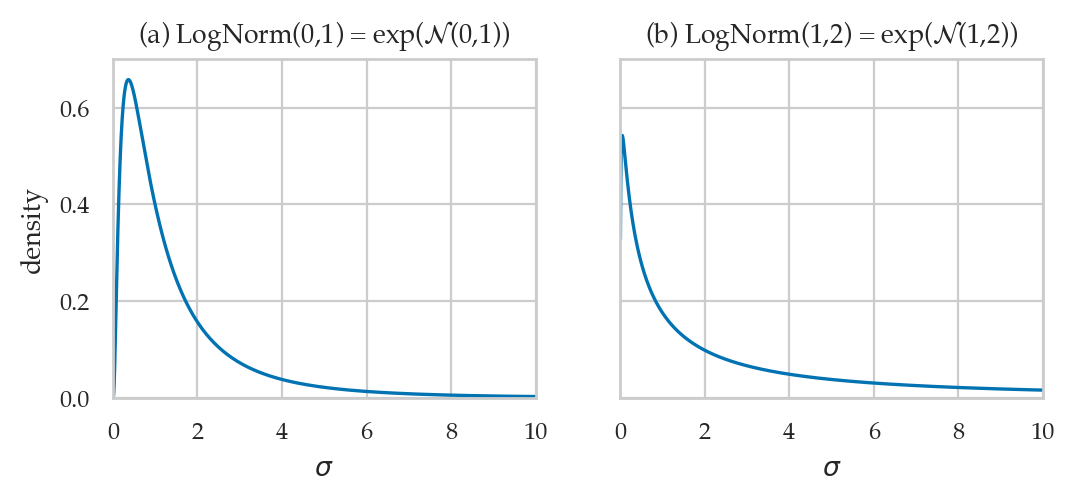

In [9]:
from scipy.stats import norm

def get_lognormal(mu=0, sigma=1):
    logsigs = np.linspace(-5, 5, 1000)
    dlogsigs = norm(mu, sigma).pdf(logsigs)
    sigmas = np.exp(logsigs)
    # Apply the change of variables to get the density for sigma
    # based on the Jacobian |d(log(sigma))/d(sigma)| = 1/sigma
    dsigmas = dlogsigs / sigmas
    return sigmas, dsigmas


with plt.rc_context({"figure.figsize":(6,2.2)}):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    # PLOT 1
    mu, sigma = 0, 1
    sigmas, dsigmas = get_lognormal(mu, sigma)
    sns.lineplot(x=sigmas, y=dsigmas, ax=ax1)
    ax1.set_xlabel('$\\sigma$')
    ax1.set_ylabel('density')
    ax1.set_title(f'(a) LogNorm({mu},{sigma}) = exp($\\mathcal{{N}}$({mu},{sigma}))')
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 0.7)

    # PLOT 2
    mu, sigma = 1, 2
    sigmas, dsigmas = get_lognormal(mu, sigma)
    sns.lineplot(x=sigmas, y=dsigmas, ax=ax2)
    ax2.set_xlabel('$\\sigma$')
    ax2.set_ylabel('density')
    ax2.set_title(f'(b) LogNorm({mu},{sigma}) = exp($\\mathcal{{N}}$({mu},{sigma}))')
    ax2.set_xlim(0, 10)

### Choosing priors for the degrees of freedom parameter

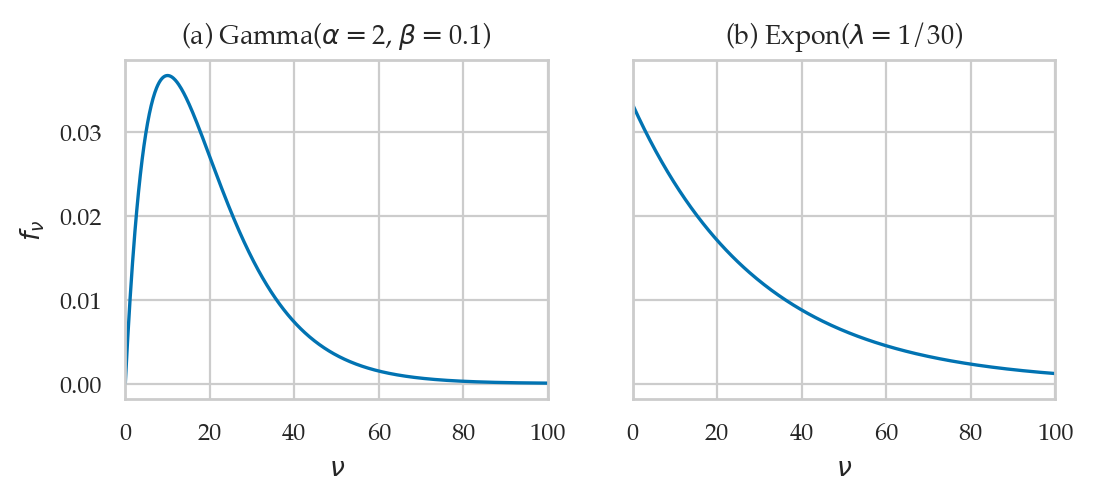

In [10]:
# FIGURES ONLY
from scipy.stats import gamma as gammadist
from scipy.stats import expon
from ministats import plot_pdf

with plt.rc_context({"figure.figsize":(6,2.2)}):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    # PLOT 1
    alpha, beta = 2, 0.1
    rv_nu = gammadist(a=2, scale=1/beta)
    plot_pdf(rv_nu, rv_name="ν", ax=ax1)
    ax1.set_title(f'(a) Gamma($\\alpha=${alpha}, $\\beta=${beta})')
    ax1.set_xlim(0, 100)

    # PLOT 2
    scale = 30
    rv_nu_exp = expon(scale=scale)
    plot_pdf(rv_nu_exp, rv_name="ν", ax=ax2)
    ax2.set_title(f'(b) Expon($\\lambda=$1/{scale})')
    ax2.set_xlim(0, 100)

## Example 1: comparing electricity prices

Electricity prices from East End and West End

### Electricity prices dataset

In [11]:
eprices = pd.read_csv("datasets/eprices.csv")
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [12]:
eprices["price"].mean(), eprices["price"].std()

(7.655555555555556, 1.973120020267162)

### Bayesian model


\begin{align*}
    X_W \sim \mathcal{T}(\nu, M_W, \Sigma_W),
    \qquad  \qquad
    X_E \sim \mathcal{T}(\nu, M_E, \Sigma_E), \qquad\qquad \\
    M_W, M_E \!\sim\! \mathcal{N}(\mu_{M}, \sigma_{M}),
    \quad
    \log\Sigma_W, \log\Sigma_E\!\sim\!\mathcal{N}(0,1),
    \quad
    \nu \!\sim\! \text{Gamma}(2,0.1).
\end{align*}

### Bambi model


In [13]:
formula1 = bmb.Formula("price ~ 0 + loc",
                       "sigma ~ 0 + loc")

links1 = {"mu":"identity",
          "sigma":"log"}

priors1 = {
    "loc": bmb.Prior("Normal", mu=8, sigma=5),
    "sigma": {
        "loc": bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod1 = bmb.Model(formula=formula1,
                 family="t",
                 link=links1,
                 priors=priors1,
                 data=eprices)
mod1

       Formula: price ~ 0 + loc
                sigma ~ 0 + loc
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 18
        Priors: 
    target = mu
        Common-level effects
            loc ~ Normal(mu: 8.0, sigma: 5.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_loc ~ Normal(mu: 0.0, sigma: 1.0)

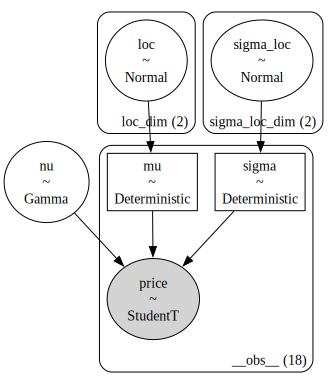

In [14]:
mod1.build()
mod1.graph()

### Prior predictive checks

In [15]:
# TODO

### Model fitting and analysis

In [16]:
idata1 = mod1.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Processing the results

Calculate derived quantities used for the analysis plots and summaries.

In [17]:
post1 = idata1["posterior"]

# Calculate sigmas from log-sigmas
#######################################################
logsig_W = post1["sigma_loc"].sel(sigma_loc_dim="West")
logsig_E = post1["sigma_loc"].sel(sigma_loc_dim="East")
post1["sigma_West"] = np.exp(logsig_W)
post1["sigma_East"] = np.exp(logsig_E)

# Calculate the difference between between means
post1["mu_West"] = post1["loc"].sel(loc_dim="West")
post1["mu_East"] = post1["loc"].sel(loc_dim="East")
post1["dmeans"] = post1["mu_West"] - post1["mu_East"]

# Calculate the difference between standard deviations
post1["dsigmas"] = post1["sigma_West"]-post1["sigma_East"]

# Effect size
#######################################################
pvar =(post1["sigma_West"]**2+post1["sigma_East"]**2)/2
post1["cohend"] = post1["dmeans"] / np.sqrt(pvar)

In [18]:
# #ALT: use helper function
# from ministats import calc_dmeans_stats
# calc_dmeans_stats(idata1, group_name="loc")

In [19]:
az.summary(idata1, kind="stats", hdi_prob=0.90,
           var_names=["mu_West", "mu_East", "dmeans", "sigma_West", "sigma_East", "dsigmas", "nu", "cohend"])

,mean,sd,hdi_5%,hdi_95%
mu_West,9.116,0.559,8.236,10.031
mu_East,6.158,0.339,5.637,6.710
dmeans,2.958,0.660,1.852,3.991
sigma_West,1.575,0.444,0.884,2.244
sigma_East,0.918,0.282,0.483,1.298
dsigmas,0.657,0.521,-0.166,1.521
nu,21.071,14.394,2.060,41.240
cohend,2.372,0.709,1.191,3.509


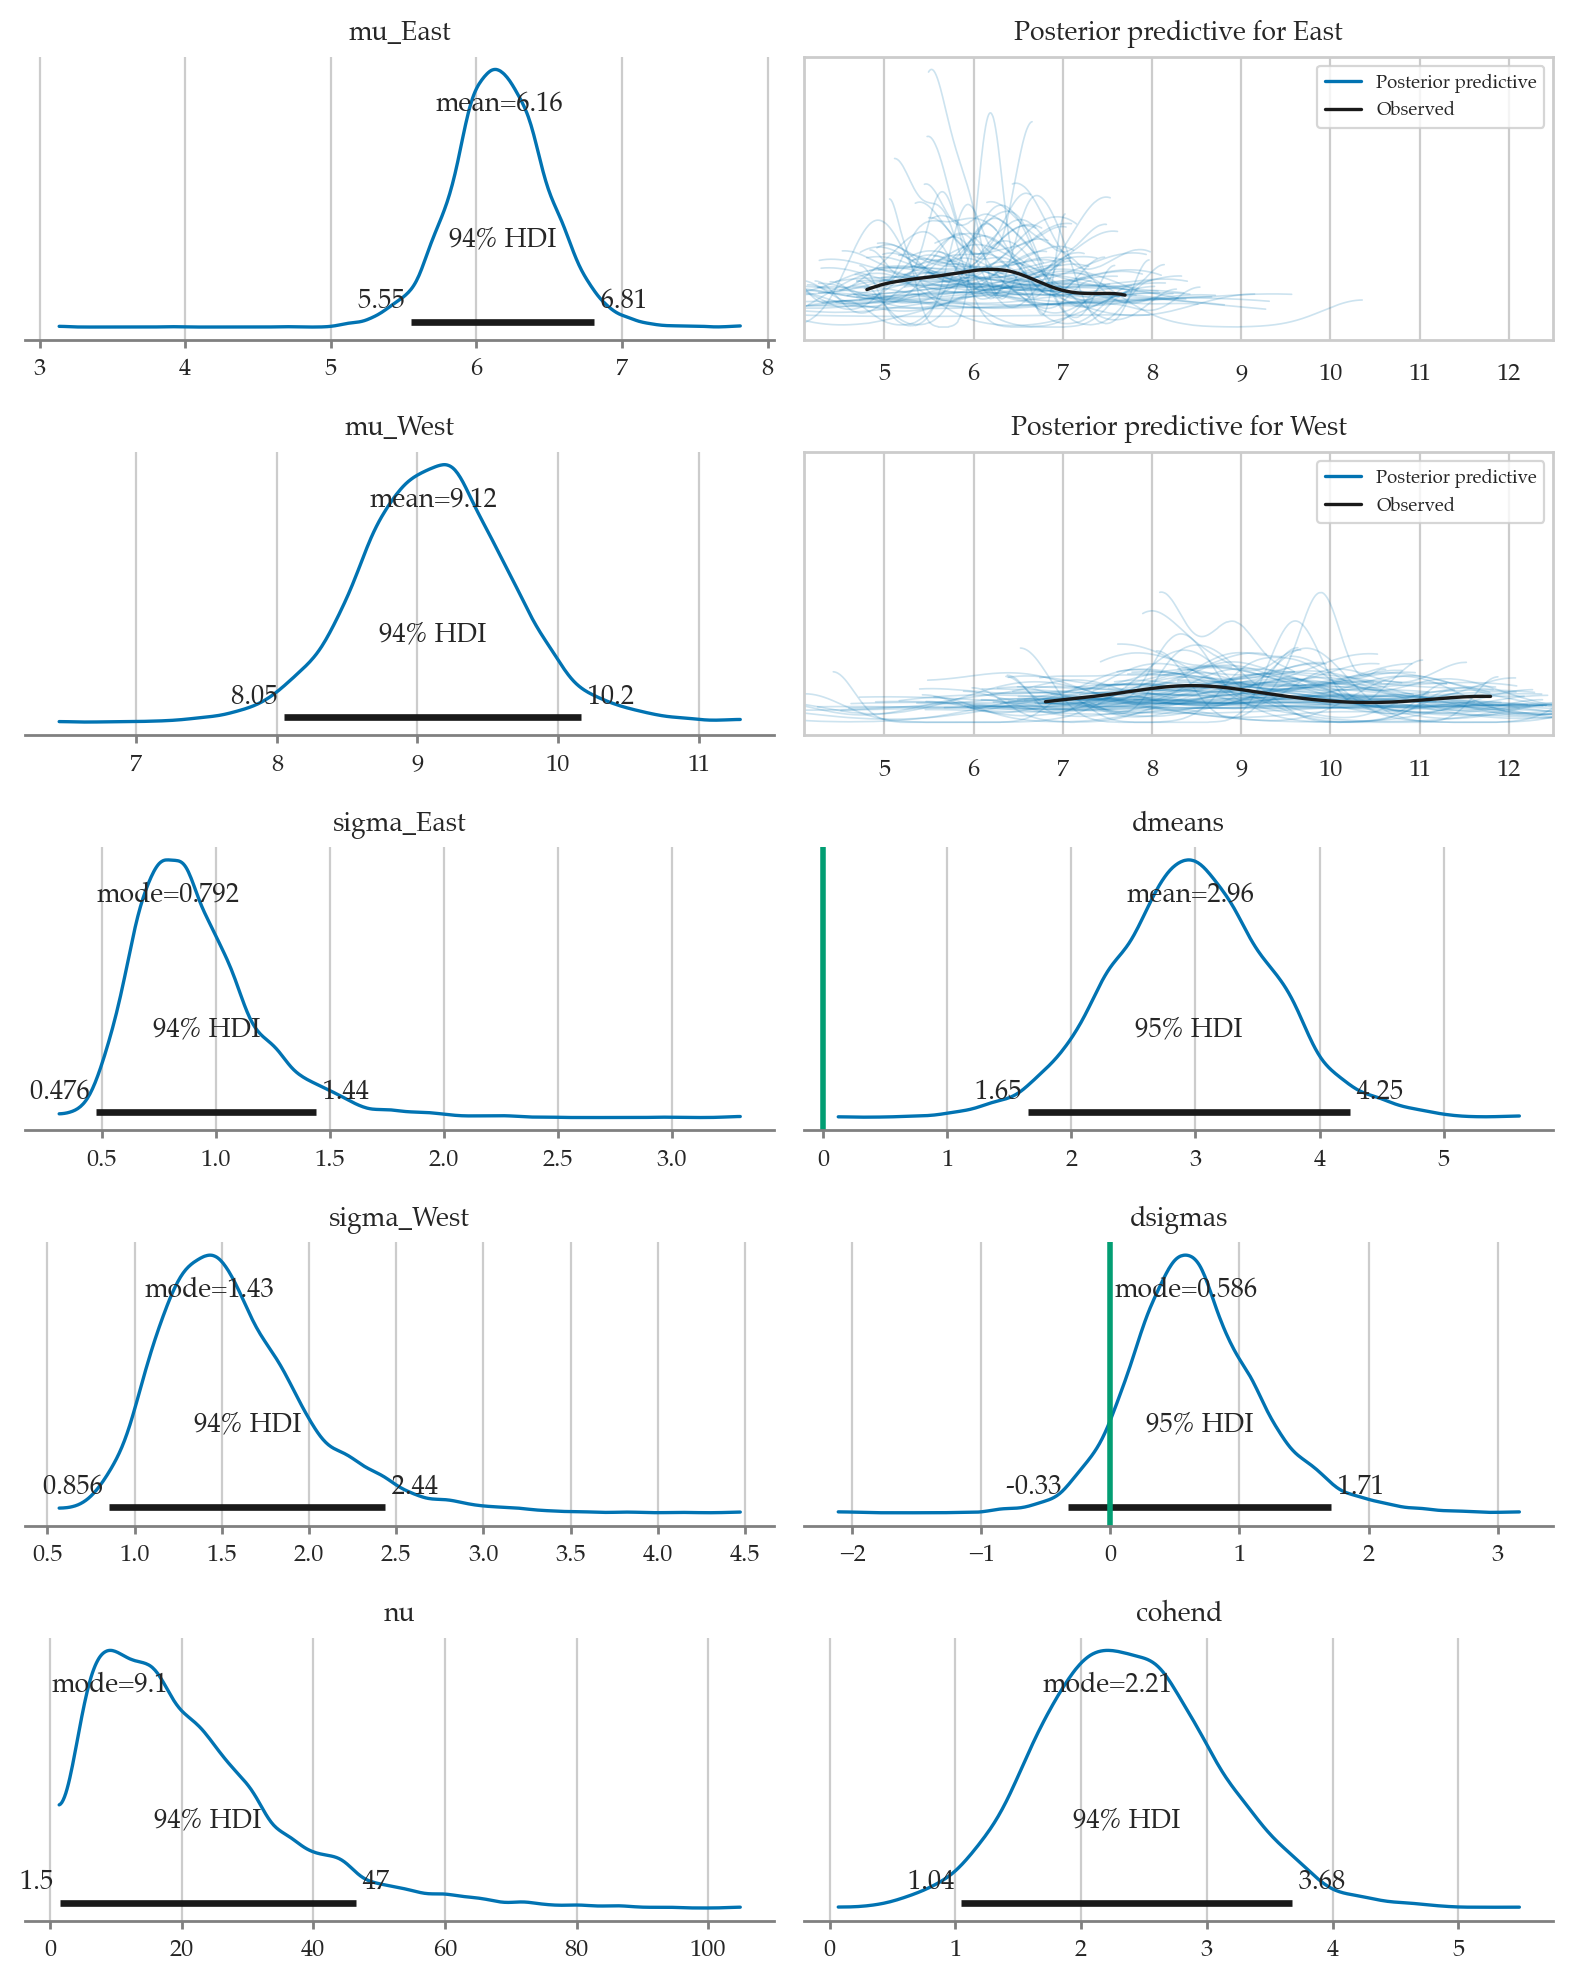

In [20]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

### Compare to frequentist results

In [21]:
from scipy.stats import ttest_ind
pricesW = eprices[eprices["loc"]=="West"]["price"]
pricesE = eprices[eprices["loc"]=="East"]["price"]

res1 = ttest_ind(pricesW, pricesE, equal_var=False)
res1.statistic, res1.pvalue

(5.022875513276464, 0.00025703383372176116)

In [22]:
res1.confidence_interval(confidence_level=0.9)

ConfidenceInterval(low=1.9396575883681466, high=4.060342411631854)

In [23]:
from ministats import cohend2
cohend2(pricesW, pricesE)

2.3678062243290996

### Conclusions

## Example 2: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

smart drug administered to `treatment` group and want to compare to `control` group. Data contains outliers)

cf. [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)

### IQ scores dataset

In [24]:
iqs2 = pd.read_csv("datasets/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


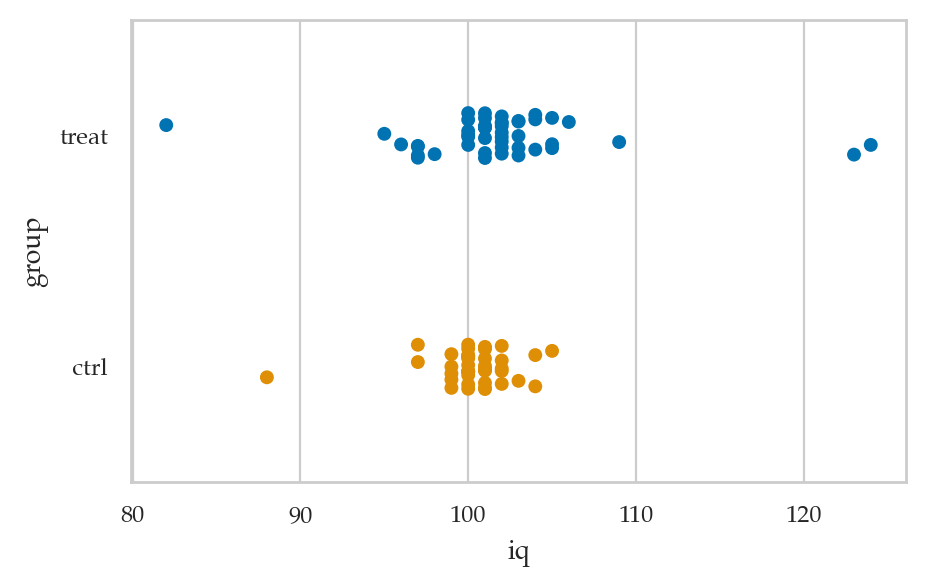

In [25]:
sns.stripplot(data=iqs2, x="iq", y="group", hue="group");

### Bayesian model
TODO: add formulas

### Bambi model

In [26]:
formula2 = bmb.Formula("iq ~ 0 + group",
                       "sigma ~ 0 + group")

priors2 = {
    "group": bmb.Prior("Normal", mu=100, sigma=35),
    "sigma": {
        "group": bmb.Prior("Normal", mu=1, sigma=2)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 # link={"mu":"identity", "sigma":"log"}, # Bambi defaults
                 priors=priors2,
                 data=iqs2)

mod2

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 100.0, sigma: 35.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 1.0, sigma: 2.0)

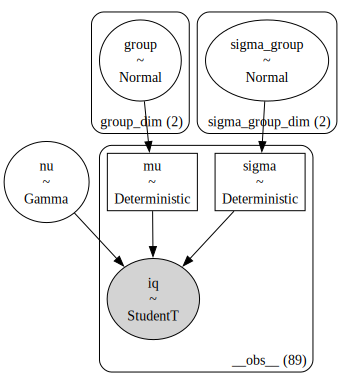

In [27]:
mod2.build()
mod2.graph()

### Model fitting and analysis

In [28]:
idata2 = mod2.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [29]:
from ministats import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="group");
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["mu_treat", "mu_ctrl", "dmeans", "sigma_treat", "sigma_ctrl", "dsigmas", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
mu_treat,101.546,0.374,100.827,102.298
mu_ctrl,100.522,0.211,100.116,100.949
dmeans,1.025,0.435,0.131,1.823
sigma_treat,2.013,0.421,1.207,2.821
sigma_ctrl,1.032,0.204,0.678,1.459
dsigmas,0.980,0.432,0.188,1.865
nu,1.857,0.496,1.009,2.812
cohend,0.662,0.306,0.088,1.270


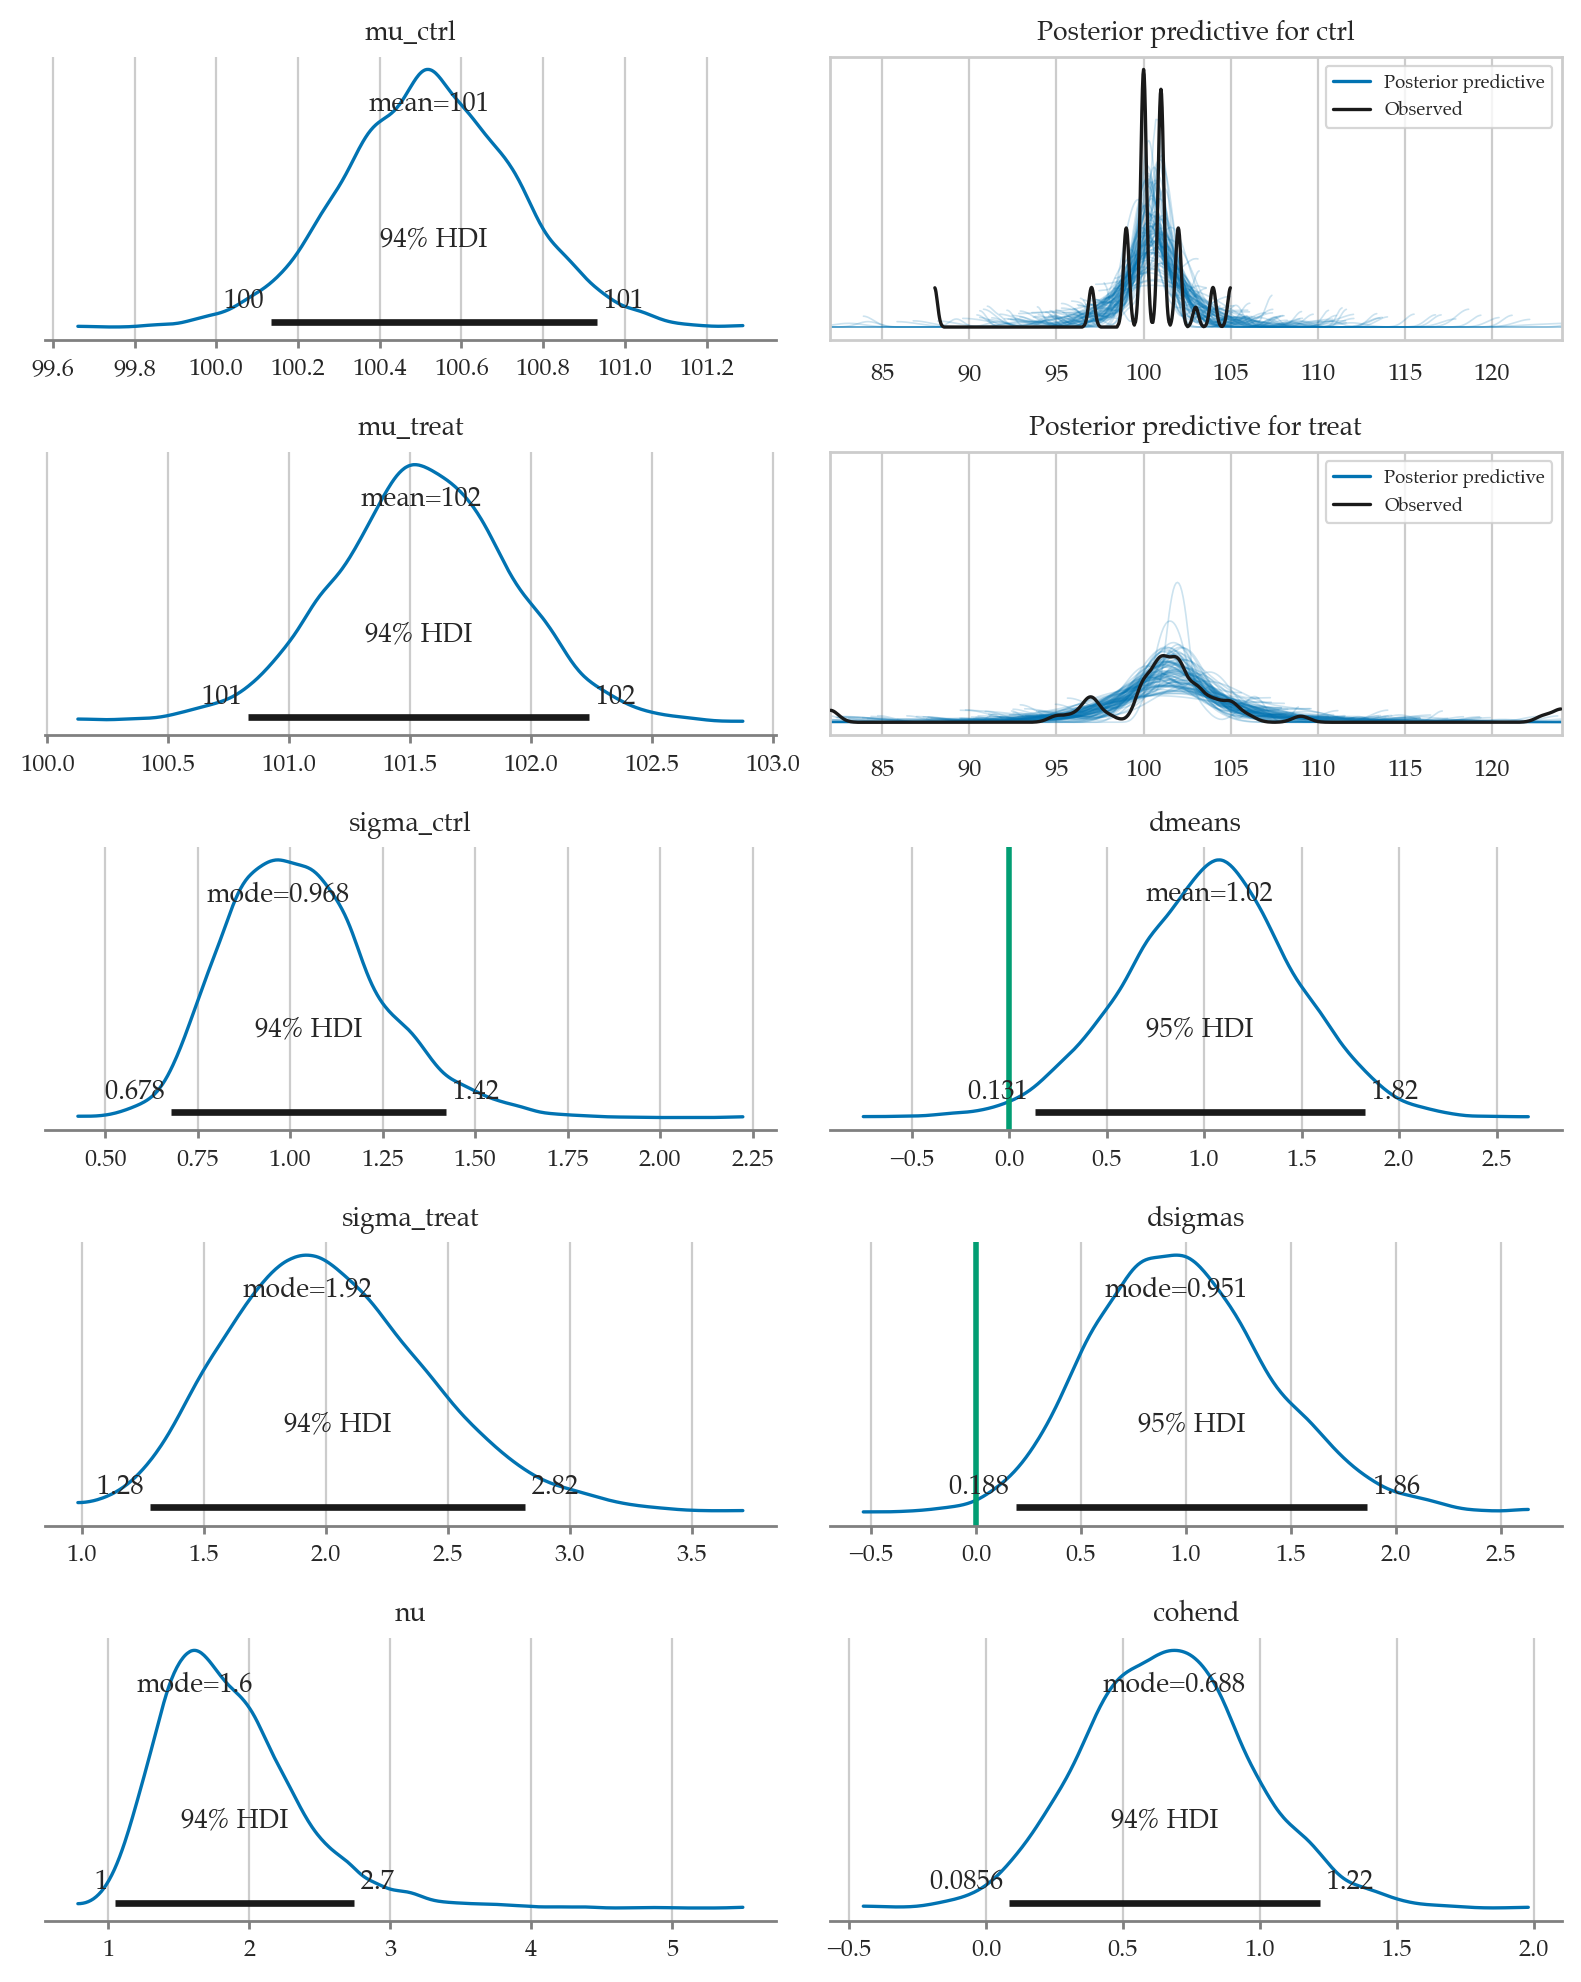

In [30]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, group_name="group", ppc_xlims=[82,124]);

### Sensitivity analysis

In [31]:
from ministats.book.tables import sens_analysis_dmeans_iqs2
results = sens_analysis_dmeans_iqs2(iqs2)
results

,M_prior,logSigma_prior,Nu_prior,dmeans_mean,dmeans_95hdi,dsigmas_mode,dsigmas_95hdi,nu_mode,codhend_mode
0,"$\mathcal{N}(100,35)$","$\mathcal{N}(1,2)$","$\Gamma(2,0.1)$",1.033,"[0.141, 1.843]",0.887,"[0.19, 1.868]",1.633,0.887
1,"$\mathcal{N}(100,50)$","$\mathcal{N}(1,2)$","$\Gamma(2,0.1)$",1.021,"[0.195, 1.888]",0.927,"[0.186, 1.868]",1.627,0.927
2,"$\mathcal{N}(100,10)$","$\mathcal{N}(1,2)$","$\Gamma(2,0.1)$",1.028,"[0.201, 1.911]",0.876,"[0.175, 1.821]",1.634,0.876
3,"$\mathcal{N}(100,35)$","$\mathcal{N}(0,1)$","$\Gamma(2,0.1)$",1.02,"[0.208, 1.855]",0.851,"[0.184, 1.783]",1.596,0.851
4,"$\mathcal{N}(100,35)$","$\mathcal{N}(1,2)$",$\textrm{Expon}(1/30)$,1.033,"[0.192, 1.855]",0.917,"[0.175, 1.803]",1.587,0.917


### Compare to frequentist results

In [32]:
from scipy.stats import ttest_ind

treated = iqs2[iqs2["group"]=="treat"]["iq"]
controls = iqs2[iqs2["group"]=="ctrl"]["iq"]

res2 = ttest_ind(treated, controls, equal_var=False)
res2.statistic, res2.pvalue

(1.622190457290228, 0.10975381983712836)

In [33]:
res2.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=-0.36118477236636837, high=3.4766862921232016)

In [34]:
from ministats import cohend2
cohend2(treated, controls)

0.33096545301397307

In [35]:
# MAYBE
# # Test if the variances of the two groups are the same
# from scipy.stats import levene
# levene(treated, controls)

### Conclusions

## Explanations


### Alternative choices of priors
e.g. prior for sigma as very wiiiiiide, and  nu ~ Exp(1/29)+1 → BEST
Bayesian estimation supersedes the t-test by John K. Kruschke
- https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf 
- https://www.sumsar.net/blog/2013/06/best-online/ 

If we use a model with common standard deviation, we get equivalent of pooled sigma


In [36]:
# TODO

## Performance tests

### Simulated datasets

Simulate datasets with various combinations of $n$, $\Delta$, and outliers.

In [37]:
from ministats.book.tables import gen_dmeans_datasets

ns = [20, 30, 50, 100]
Deltas = [0, 0.2, 0.5, 0.8, 1.3]
outliers_options = ["no", "few", "lots"]
dataset_specs = gen_dmeans_datasets(ns=ns,
                                    Deltas=Deltas,
                                    outliers_options=outliers_options)
dataset_specs[0:4]

[{'n': 20, 'Delta': 0, 'outliers': 'no', 'random_seed': 45},
 {'n': 20, 'Delta': 0, 'outliers': 'few', 'random_seed': 46},
 {'n': 20, 'Delta': 0, 'outliers': 'lots', 'random_seed': 47},
 {'n': 20, 'Delta': 0.2, 'outliers': 'no', 'random_seed': 48}]

### Model comparisons

Compare results several models:
- Classical permutation test (from Section 4.5)
- Classical Welch's two-sample t-test (from Section 4.5)
- Bayesian model with $\mathcal{N}$ data model
- Robust Bayesian model with $\mathcal{T}$ data model
- Bayes factors with JZS prior and standard cutoff

In [38]:
from ministats.book.tables import fit_dmeans_models
help(fit_dmeans_models)

Help on function fit_dmeans_models in module ministats.book.tables:

fit_dmeans_models(dataset, random_seed=42)
    Fit the following models for the difference of two means:
    - Permutation test from Section 3.5
    - Welch's two-sample $t$-test from Section 3.5
    - Bayesian model that uses normal as data model
    - Robust Bayesian model that uses t-distribution as data model
    - Bayes factor using JZS prior (using `pingouin` library)
    For each model, we run the hypothesis test to decide if the populations
    are the same or different based on the conventional cutoff level of 5%.
    We also construct a 90% interval estimates for the unknown `Delta`.



### Results

In [39]:
# Download simdata/ directory if necessary
from ministats import ensure_simdata
ensure_simdata()

# Option A: load results from simulation
filename = "dmeans_perf_metrics__" \
            + "ns_20_30_50_100__" \
            + "Deltas_0_0.2_0.5_0.8_1.3__" \
            + "outs_no_few_lots__reps_100.csv"
results = pd.read_csv(os.path.join("simdata", filename), index_col=[0,1])
results.head(3)
# Option B: run full simulation (takes about three days)
# from ministats.book.tables import calc_dmeans_perf_metrics
# results = calc_dmeans_perf_metrics(reps=100)

simdata/ directory present and ready.


n  Delta outliers  seed  count_reject  count_fail_to_reject  \
spec model                                                                      
0    perm        20    0.0       no    45             6                    94   
     welch       20    0.0       no    45             6                    94   
     norm_bayes  20    0.0       no    45             2                    98   

                 count_captured  avg_width  
spec model                                  
0    perm                  90.0   1.011714  
     welch                 90.0   1.065525  
     norm_bayes            94.0   1.294730

### Type I (false positive) error rates 

In [40]:
from ministats.book.tables import get_perf_table_typeI

tableA = get_perf_table_typeI(results)
tableA

model         perm  welch  norm_bayes  robust_bayes    bf
outliers n                                               
no       20   0.06   0.06        0.02          0.07  0.02
         30   0.04   0.04        0.03          0.04  0.03
         50   0.04   0.04        0.01          0.04  0.01
         100  0.06   0.06        0.03          0.05  0.01
few      20   0.04   0.04        0.01          0.05  0.01
         30   0.04   0.04        0.01          0.05  0.00
         50   0.03   0.03        0.02          0.01  0.00
         100  0.07   0.07        0.06          0.08  0.03
lots     20   0.04   0.02        0.01          0.03  0.01
         30   0.02   0.02        0.00          0.02  0.00
         50   0.07   0.06        0.06          0.07  0.04
         100  0.03   0.03        0.03          0.02  0.00

Observations:

- all models are about the same
- BF model has significantly less false positives

### Power analysis

In [41]:
from ministats.book.tables import get_perf_table_power

tableB = get_perf_table_power(results, show_all=False)
tableB

model               perm  welch  norm_bayes  robust_bayes    bf
outliers Delta n                                               
no       0.5   30   0.46   0.46        0.33          0.46  0.31
               50   0.68   0.69        0.54          0.66  0.50
               100  0.93   0.93        0.90          0.93  0.84
         0.8   20   0.60   0.60        0.44          0.59  0.49
               30   0.86   0.86        0.77          0.86  0.72
               50   0.99   0.99        0.96          0.99  0.93
few      0.5   30   0.49   0.49        0.32          0.45  0.29
               50   0.49   0.51        0.39          0.58  0.33
               100  0.80   0.80        0.80          0.88  0.69
         0.8   20   0.69   0.68        0.51          0.65  0.54
               30   0.88   0.88        0.79          0.87  0.78
               50   0.85   0.85        0.83          0.94  0.75
lots     0.5   30   0.33   0.32        0.29          0.43  0.20
               50   0.52   0.52        0.50          0.63  0.33
               100  0.64   0.63        0.60          0.88  0.52
         0.8   20   0.44   0.43        0.37          0.63  0.30
               30   0.60   0.59        0.57          0.81  0.48
               50   0.82   0.83        0.79          0.97  0.66

Observations:

- Bayes $\mathcal{T}$ has higher power than Bayes $\mathcal{N}$
- Bayes $\mathcal{T}$ outperforms all other models when outliers are present

### Interval estimates coverage

In [42]:
from ministats.book.tables import get_perf_table_coverage

tableC = get_perf_table_coverage(results)
tableC

model            perm              welch           norm_bayes            \
             coverage avg_width coverage avg_width   coverage avg_width   
outliers n                                                                
no       20    0.8800  1.011711   0.9050  1.064862     0.9650  1.298070   
         30    0.9100  0.821001   0.9175  0.849298     0.9625  1.016220   
         50    0.9050  0.651732   0.9100  0.665610     0.9525  0.762513   
         100   0.9025  0.462228   0.9025  0.467091     0.9325  0.517568   
few      20    0.8550  1.002797   0.8675  1.056252     0.9500  1.294572   
         30    0.9175  0.835295   0.9250  0.864310     0.9625  1.022407   
         50    0.8675  0.784709   0.9025  0.802027     0.9350  0.854340   
         100   0.8725  0.554332   0.8975  0.560776     0.9125  0.581300   
lots     20    0.8700  1.442238   0.9025  1.530370     0.9450  1.601472   
         30    0.8550  1.085291   0.8700  1.128444     0.9000  1.197037   
         50    0.8825  0.892523   0.8975  0.913113     0.9175  0.937645   
         100   0.8975  0.679404   0.9025  0.686951     0.9175  0.688840   

model        robust_bayes            
                 coverage avg_width  
outliers n                           
no       20        0.9100  1.078473  
         30        0.9225  0.855460  
         50        0.9100  0.667750  
         100       0.9075  0.467747  
few      20        0.8700  1.069132  
         30        0.9250  0.872108  
         50        0.9075  0.695260  
         100       0.9275  0.487010  
lots     20        0.8975  1.197020  
         30        0.8550  0.926892  
         50        0.9075  0.726270  
         100       0.8950  0.509295

Observations:

- All methods have coverage close to the nominal 90\%
- Bayes $\mathcal{T}$ produces narrower intervals


## Discussion

### Comparison to the frequentist two-sample t-test

- results numerically similar
- note we're using 𝒯 as data model, not as a sampling distribution
- conceptually different:
  - p-value vs. decision based on posterior distribution
  - confidence intervals vs. credible intervals

### Comparing multiple groups

- ?Extension to Bayesian ANOVA? Can extend approach to multiple groups: Bayesian ANOVA

FWD reference to hierarchical models for group comparison covered in Section 5.5


## Exercises

### Exercise 1: small samples

In [43]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

### Exercise 2: lecture and debate curriculums

In [44]:
students = pd.read_csv("datasets/students.csv")
# students.groupby("curriculum")["score"].describe()

In [45]:
formula_std = bmb.Formula("score ~ 0 + curriculum",
                          "sigma ~ 0 + curriculum")
priors_std = {
    "curriculum": bmb.Prior("Normal", mu=70, sigma=30),
    "sigma": {
        "curriculum":bmb.Prior("Normal", mu=1, sigma=2)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}
mod_std = bmb.Model(formula=formula_std,
                 family="t",
                 link="identity",
                 priors=priors_std,
                 data=students)
mod_std
# mod_std.build()
# mod_std.graph()

       Formula: score ~ 0 + curriculum
                sigma ~ 0 + curriculum
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            curriculum ~ Normal(mu: 70.0, sigma: 30.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_curriculum ~ Normal(mu: 1.0, sigma: 2.0)

In [46]:
idata_std = mod_std.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [47]:
# Calculate the difference between between means
currs = idata_std["posterior"]["curriculum"]
mu_debate = currs.sel(curriculum_dim="debate")
mu_lecture = currs.sel(curriculum_dim="lecture")
idata_std["posterior"]["dmeans"] = mu_debate - mu_lecture
az.summary(idata_std, kind="stats", var_names=["dmeans"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,7.375,5.313,-2.916,18.167


In [48]:
# from ministats import plot_dmeans_stats
# plot_dmeans_stats(mod_std, idata_std, ppc_xlims=[50,100], group_name="curriculum");

In [49]:
# from scipy.stats import ttest_ind
# scoresD = students[students["curriculum"]=="debate"]["score"]
# scoresL = students[students["curriculum"]=="lecture"]["score"]
# res_std = ttest_ind(scoresD, scoresL, equal_var=False)
# res_std.statistic, res_std.pvalue
# from ministats import cohend2
# cohend2(scoresL, scoresD)

### Exercise 3: redo exercises from Section 3.5 section using Bayesian methods

In [50]:
# TODO

## Links

TODO

# BONUS Examples

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [51]:
# y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
# y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

# from ministats.bayes import bayes_dmeans
# mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

In [52]:
# from ministats import calc_dmeans_stats
# calc_dmeans_stats(idata4)
# az.summary(idata4, kind="stats", hdi_prob=0.95,
#            var_names=["dmeans", "sigma_y1", "sigma_y2", "dsigmas", "nu", "cohend"])

In [53]:
# from ministats import plot_dmeans_stats
# plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [54]:
# morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
#            9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
# evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
#            9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [55]:
# from ministats.bayes import bayes_dmeans
# mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

In [56]:
# from ministats import calc_dmeans_stats
# calc_dmeans_stats(idata5)
# az.summary(idata5, kind="stats", hdi_prob=0.95,
#            var_names=["dmeans", "sigma_evening", "sigma_morning", "dsigmas", "nu", "cohend"])

In [57]:
# from ministats import plot_dmeans_stats
# plot_dmeans_stats(mod5, idata5, ppc_xlims=None);